# Chapter 6. 차원축소

### 다중공선성이란?

다중공선성이란 독립변수들간에 강한 상관관계가 존재하는 경우를 말함.  
다중공선성이 존재하면 회귀분석의 전제조건(서로 독립)을 위반하게 된다.   
다중공선성이 존재하면 상관관계가 높지만 상관관계가 높다고 해서 반드시 다중공선성이 존재하는 것은 아님.

다중공선성은 판단하는 기준은 '분산 팽창 인수'로   
보통 10 이상일 때 심각한 다중공선성 존재한다고 판단, 5이상이면 다중공선성 존재 가능성 있다고 판단.

### 다중공선성 해결방법 

1. 다중공선성에 영향을 주는 변수 제거.(변수선택법)  

2. 주성분 분석 이용(변수추출법)하여 서로 독립인 새로운 변수 생성한다.(범주형 데이터에서는 사용 불가.)  
3. 다른 모형 선택 (Ridge regression)

# PCA(Principal Component Analysis, 주성분분석)

입력 데이터의 공분산 행렬이 고유벡터와 고유값으로 분해될 수 있으며,  
이렇게 분해된 고유벡터를 이용해 입력 데이터를 선형 변환하는 방식.

## 붓꽃 데이터 활용 PCA

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
# %matplotlib inline # notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것

iris = load_iris()
# 넘파이 데이터세트를 판다스 DataFrame으로 변환
columns = ['sepal_length','sepal_width','petal_length','petal_width']
irisDF = pd.DataFrame(iris.data, columns = columns)
irisDF['target'] = iris.target
irisDF.head(3)

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


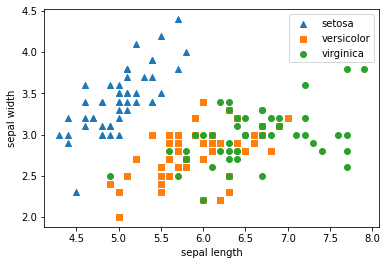

In [5]:
## 원본 붓꽃 데이터 세트 분포 2차원 시각화 (sepal_length, sepal_width)
# setosa는 세모, versicolor는 네모, virginica는 동그라미
markers = ['^','s','o']

# setosa의 target값은 0, versicolor는 1, virginica는 2. 각 target별로 다른 모양 산점도로 표시
for i, marker in enumerate(markers):
    x_axis_data = irisDF[irisDF['target']==i]['sepal_length']
    y_axis_data = irisDF[irisDF['target']==i]['sepal_width']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=iris.target_names[i])

plt.legend()
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

<AxesSubplot:xlabel='sepal_length', ylabel='sepal_width'>

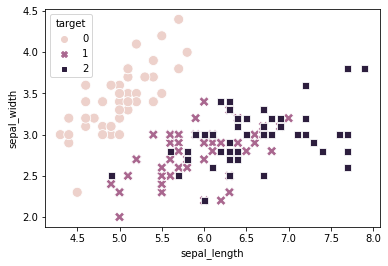

In [6]:
## 위 산점도 seaborn으로 다시 그려보기.
import seaborn as sns
plt.figure(figsize=(6,4))
sns.set_palette("bright")
sns.scatterplot(data=irisDF, x='sepal_length', y='sepal_width',  hue='target', style='target',
               s=100) # point 크기

### 4개 속성을 2개로 압축한 뒤 2차원 시각화

In [7]:
## 개별 속성 스케일링(표준화)
from sklearn.preprocessing import StandardScaler

# Target값 제외 모든 속성 값을 StandardScaler 이용하여 표준 정규 분포 가지는 값으로 변환
iris_scaled = StandardScaler().fit_transform(irisDF.iloc[:,:-1]) # target 제외

In [8]:
## 4개 속성 2개 속성으로 압축
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# fit()과 transform() 호출해 PCA 변환 데이터 반환
pca.fit(iris_scaled)
iris_pca = pca.transform(iris_scaled)
print(iris_pca.shape)

(150, 2)


In [9]:
## PCA 변환된 데이터는 넘파이행렬이므로 이를 DataFrame으로 변환
# PCA 변환된 데이터의 칼럼 명 각각 pca_component_1, pca_component_2로 명명
pca_columns = ['pca_component_1','pca_component_2']
irisDF_pca = pd.DataFrame(iris_pca, columns=pca_columns)
irisDF_pca['target']=iris.target
irisDF_pca.head(3)

,pca_component_1,pca_component_2,target
0,-2.264703,0.480027,0
1,-2.080961,-0.674134,0
2,-2.364229,-0.341908,0


<AxesSubplot:xlabel='pca_component_1', ylabel='pca_component_2'>

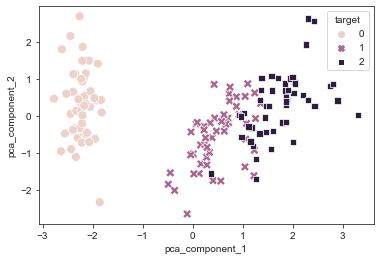

In [10]:
## PCA 변환된 데이터 시각화
plt.figure(figsize=(6,4))
sns.set_style('ticks') # 배경 흰색 + 눈금자 없애기
sns.scatterplot(data=irisDF_pca, x='pca_component_1', y='pca_component_2',
               hue='target',style='target', s=80)

### x축 기반으로 0 명확하게 구분 가능, 1,2 품종도 이전에 비해 비교적 명확히 구분 가능!

In [11]:
## PCA component별 원본 데이터의 변동성 얼마나 반영하는지 확인
print(pca.explained_variance_ratio_) 

[0.72962445 0.22850762]


첫 번째 PCA 변환 요소인 pca_component_1이 전체 변동성의 약 72.9% 차지  
두 번째 PCA 변환 요소인 pca_component_2가 전체 변동성의 약 22.8% 차지  
2개 요소만으로 원본 데이터의 변동성 약 95% 설명 가능

### 원본 데이터세트와 PCA로 변환된 데이터 세트 각각 분류성능 확인

In [12]:
## Estimator RandomForestClassifier 사용, cross_val_score() 로 3개의 교차 검증 세트 정확도 결과 비교.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# 원본 데이터 랜덤포레스트 적용
rcf = RandomForestClassifier(random_state=156)
scores = cross_val_score(rcf, iris.data, iris.target, scoring='accuracy',cv=3)

# PCA 변환 데이터 랜덤포레스트 적용
scores_pca = cross_val_score(rcf, irisDF_pca.iloc[:,:2], iris.target, scoring='accuracy', cv=3)

print('원본 데이터 교차 검증 개별 정확도:',scores)
print('원본 데이터 평균 정확도:',np.mean(scores))
print('\nPCA 변환 데이터 교차 검증 개별 정확도:',scores_pca)
print('PCA 변환 데이터 평균 정확도:', np.mean(scores_pca))

원본 데이터 교차 검증 개별 정확도: [0.98 0.94 0.96]
원본 데이터 평균 정확도: 0.96

PCA 변환 데이터 교차 검증 개별 정확도: [0.88 0.88 0.88]
PCA 변환 데이터 평균 정확도: 0.88


## 신용카드 데이터

In [13]:
# header로 의미 없는 첫 행 제거, iloc으로 기존 id 제거

df = pd.read_excel('credit_card.xls', header=1, sheet_name='Data').iloc[:,1:]
print(df.shape)
df.head(3)

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


Target : default payment next month   
다음달 연체 여부 의미하며 연체일 경우 1, 정상납부일 경우 0

In [14]:
## 원본 데이터 세트 Pay_0 -> PAY_1로 변경, target변수명 너무 길어 default로 변경 후 별도 저장 & 피처 데이터 별도 DataFrame 생성
df.rename(columns={'PAY_0':'PAY_1', 'default payment next month':'default'}, inplace=True) # 변수명 변경
y_target = df['default'] 
X_features = df.drop('default', axis=1)

<AxesSubplot:>

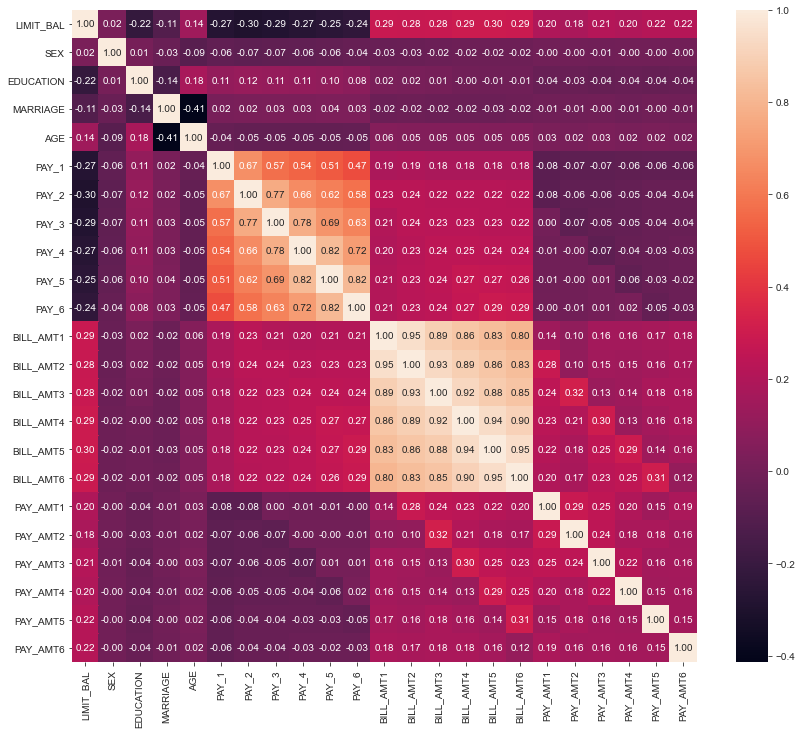

In [15]:
## 상관계수히트맵 시각화
corr = X_features.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True, fmt='.2f') # 소수점 둘 째 자리까지

BILL_AMT1 - BILL_AMT6 변수 서로 상관계수 전부 0.8이상으로 매우 높음.  
PAY_1 - PAY_6 변수 또한 대부분 0.5이상으로 높음.

In [16]:
## BILL_AMT1 ~ BILL_AMT6 6개 변수 2개의 컴포넌트로 PCA 변환 뒤 변동성 확인(explained_variance_ratio_)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# BILL_AMT1 ~ BILL_AMT6까지 6개의 변수명 생성
cols_bill = ['BILL_AMT'+str(i) for i in range(1,7)]
print('대상 변수명:', cols_bill)

# 2개의 PCA 속성을 가진 PCA 객체 생성, explained_variance_ratio_ 계산 위해 fit() 호출
scaler = StandardScaler()
df_cols_scaled = scaler.fit_transform(X_features[cols_bill])
pca = PCA(n_components=2)
pca.fit(df_cols_scaled)
print('PCA Component별 변동성:',pca.explained_variance_ratio_)

대상 변수명: ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
PCA Component별 변동성: [0.90555253 0.0509867 ]


2개 PCA컴포넌트만으로 6개 변수의 변동성을 약 95%이상 설명 가능.

### 원본 데이터 세트와 6개의 컴포넌트 PCA 변환한 데이터 세트의 분류예측결과 비교

In [17]:
## 원본데이터 예측성능 / estimator = RandomForestClassifier, 교차검증세트 = 3

rcf = RandomForestClassifier(n_estimators=300, random_state=156)
scores = cross_val_score(rcf, X_features, y_target, scoring='accuracy', cv=3)

print('CV=3 인 경우 개별 세트별 정확도:',scores)
print('평균 정확도:{0:.4f}'.format(np.mean(scores)))

CV=3 인 경우 개별 세트별 정확도: [0.8083 0.8196 0.8232]
평균 정확도:0.8170


In [18]:
## PCA 변환한 데이터 세트 예측성능

# 원본 데이터 세트에 먼저 StandardScaler 적용
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_features)

# 6개의 컴포넌트를 가진 PCA 변환 수행, cross_val_score()로 분류 예측 수행
pca = PCA(n_components=6)
df_pca = pca.fit_transform(df_scaled)
scores_pca = cross_val_score(rcf, df_pca, y_target, scoring='accuracy', cv=3)

print('CV=3인 경우의 PCA 변환된 개별 Fold 세트별 정확도:',scores_pca)
print('PCA 변환 데이터 세트 평균 정확도:{0:.4f}'.format(np.mean(scores_pca)))

CV=3인 경우의 PCA 변환된 개별 Fold 세트별 정확도: [0.79   0.7983 0.8014]
PCA 변환 데이터 세트 평균 정확도:0.7966


예측시 변수는 거의 1/4개 사용한 반면 정확도는 약 2%밖에 감소하지 않음.  
컴퓨터비전 분야에서 PCA 많이 활용.

# LDA(Linear Discriminant Analysis, 선형 판별 분석)

지도학습의 분류에서 사용하기 쉽도록 개별 클래스 분별할 수 있는 기준 최대한 유지하며 차원 축소.  
클래스 간 분산과 클래스 내부 분산의 비율을 최대화하는 방식으로 차원을 축소,  
클래스 간 분산 최대한 크게 & 클래스 내부 분산 최대한 작게.  
공분산 행렬이 아닌 클래스 간 분산과 클래스 내부 분산 행렬 생성한 뒤 이 행렬 기반 고유벡터로 입력 데이터 투영.

### 붓꽃 데이터 세트에 LDA 적용하기

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

iris = load_iris()
iris_scaled = StandardScaler().fit_transform(iris.data)

In [20]:
## 2개의 컴포넌트로 붓꽃 데이터 LDA 변환
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(iris_scaled, iris.target) # 지도학습이므로 target값 필요!!
iris_lda = lda.transform(iris_scaled)
print(iris_lda.shape)

(150, 2)


<AxesSubplot:xlabel='lda_component_1', ylabel='lda_component_2'>

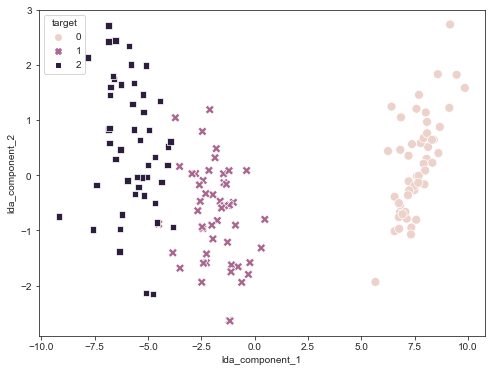

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

lda_columns=['lda_component_1','lda_component_2']
irisDF_lda = pd.DataFrame(iris_lda, columns=lda_columns)
irisDF_lda['target']=iris.target

plt.figure(figsize=(8,6))
sns.scatterplot(data=irisDF_lda, x='lda_component_1', y='lda_component_2', hue='target', style='target', s=80)

Text(0.5, 1.0, 'LDA scatterplot')

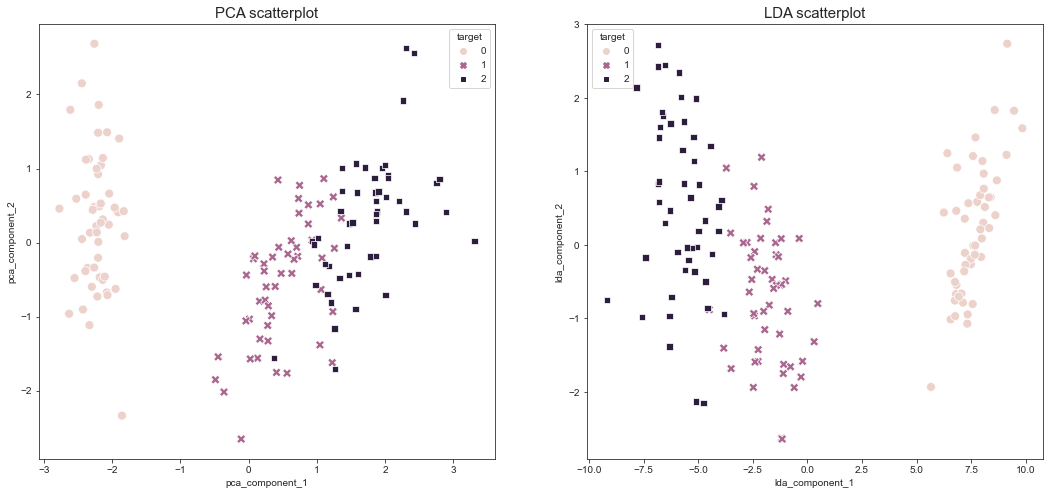

In [31]:
## PCA로 변환된 붓꽃데이터와 LDA로 변환된 붓꽃데이터 시각화 비교
# PCA 변환된 데이터 시각화
fig, ((ax1,ax2)) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(18,8)
sns.scatterplot(data=irisDF_pca, x='pca_component_1', y='pca_component_2',
               hue='target', style='target', s=80, ax=ax1)
sns.scatterplot(data=irisDF_lda, x='lda_component_1', y='lda_component_2', 
               hue='target', style='target', s=80, ax=ax2)

ax1.set_title('PCA scatterplot', fontsize=15)
ax2.set_title('LDA scatterplot', fontsize=15)

PCA에 비해 LDA로 변환한 컴포넌트1,2의 포인트들이 target구분이 좀 더 명확하다.

## 원본 데이터 분류예측 성능, PCA 변환 데이터 분류예측성능, LDA 변환 데이터 분류예측성능 비교

In [36]:
## Estimator RandomForestClassifier 사용, cross_val_score() 로 3개의 교차 검증 세트 정확도 결과 비교.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# 분류기 생성 / RandomForestClassifier
rcf = RandomForestClassifier(random_state=156)

# 원본데이터 랜덤포레스트 적용
scores = cross_val_score(rcf, iris.data, iris.target, scoring='accuracy',cv=3)

# PCA 변환 데이터 랜덤포레스트 적용
scores_pca = cross_val_score(rcf, irisDF_pca.iloc[:,:2], iris.target, scoring='accuracy', cv=3)

# LDA 변환 데이터 랜덤포레스트 적용
scores_lda = cross_val_score(rcf, irisDF_lda.iloc[:,:2], iris.target, scoring='accuracy', cv=3)

print('원본 데이터 교차 검증 개별 정확도:',scores)
print('원본 데이터 평균 정확도:',np.mean(scores))
print('\nPCA 변환 데이터 교차 검증 개별 정확도:',scores_pca)
print('PCA 변환 데이터 평균 정확도:',np.mean(scores_pca))
print('\nLDA 변환 데이터 교차 검증 개별 정확도:',scores_lda)
print('LDA 변환 데이터 평균 정확도:', np.mean(scores_lda))

원본 데이터 교차 검증 개별 정확도: [0.98 0.94 0.96]
원본 데이터 평균 정확도: 0.96

PCA 변환 데이터 교차 검증 개별 정확도: [0.88 0.88 0.88]
PCA 변환 데이터 평균 정확도: 0.88

LDA 변환 데이터 교차 검증 개별 정확도: [1.   0.9  0.96]
LDA 변환 데이터 평균 정확도: 0.9533333333333333


평균 정확도 순위 : 원본 데이터 > LDA 변환 데이터 >>> PCA 변환 데이터

## 참고사이트
다중공선성  
https://jaaamj.tistory.com/84